## Acquisition

In this notebook, we provide a code-base to display the rationale and performance of some acquisition functions implemented in ELFI. The notebook is structured as follows:
1. The rationale of the Maximum Variance (MaxVar) acquisition function applied on the 1-D Gaussian noise model;
2. The rationale of the MaxVar acqusition function applied on the 2-D Gaussian noise model;
3. A comparison between the Maxvar and LCB (ELFI default) acquisition methods.

At the start, we import the used packages and enable (or disable) the logging and seed settings.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%precision 2

import numpy as np
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt

import elfi
from elfi.examples import gauss_nd
from elfi.methods.bo.gpy_regression import GPyRegression
from elfi.methods.bo.acquisition import MaxVar, RandMaxVar
from elfi.methods.utils import ModelPrior

# import logging
# logging.basicConfig(level=logging.INFO)

seed = 20170704

### 1. Interactive acquisition of the 1-D Gaussian noise model. 

We generate the observations from the Gaussian noise model with $\mu = 4$ and use linear Mehanabolis distance (an implicit, default setting).

In [3]:
params_true_mu = [4]
model_maxvar = gauss_nd.get_model(true_params=params_true_mu, cov_ii=1, seed_obs=seed)
d_maxvar = model_maxvar['d']

Now, we set the first 2 points to be sampled from the prior; after, the points will be acquired using the MaxVar acquisition method which is set using `set_acq_method`. Note that `percentile_eps` constrains the MaxVar method to look for the maximum variance only below the set discrepancy threshold (the lower the threshold, the more difficult yet more effective the optimisation will be).

In [4]:
n_pts_initial = 2
bounds = {'mu_0':(0, 8)}
names_parameter = d_maxvar.model.parameter_names
target_model = GPyRegression(names_parameter, bounds=bounds)
prior = ModelPrior(d_maxvar.model)
method_acq = RandMaxVar(model=target_model, prior=prior, n_inits=25, seed=seed, percentile_eps=10)
# method_acq = MaxVar(model=target_model, prior=prior, n_inits=25, seed=seed, percentile_eps=10)

bolfi_maxvar = elfi.BOLFI(d_maxvar, acquisition_method=method_acq, target_model=target_model,
                          initial_evidence=n_pts_initial,
                          update_interval=1, bounds=bounds, seed=seed)

We recommend having at least 10 initialization points for the initialization (now 2)


We observe the fitting of the model by visualising the acquisition of 15 points. Note that ELFI remembers previously fit points; therefore, if `n_pts_fit` was changed to 20 and the cell was re-ran, the plots would display next 5 acquisitions. Also, note that the visualisation is enabled by setting `vis=True` in `fit`.

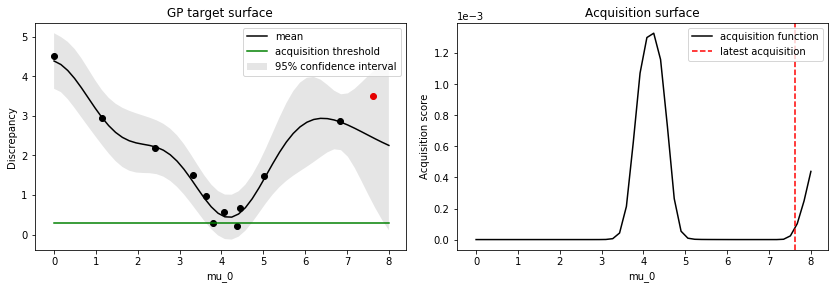

GP_regression.,value,constraints,priors
sum.rbf.variance,1.42676399157,+ve,"Ga(0.96, 1)"
sum.rbf.lengthscale,1.03273381633,+ve,"Ga(2.7, 1)"
sum.bias.variance,1.20325224612,+ve,"Ga(0.24, 1)"
Gaussian_noise.variance,0.0654486244824,+ve,


In [5]:
n_pts_fit = 10
n_pts_total = n_pts_initial + n_pts_fit
post_maxvar = bolfi_maxvar.fit(n_evidence=n_pts_total, vis=True)
# post_maxvar = bolfi_maxvar.fit(n_evidence=n_pts_total)

### 2. Interactive acquisition of the 2-D Gaussian noise model. 

We repeat the previous precedure in the 2-D Gaussian noise model. Now, $\mu = [4, 4]$.

In [6]:
params_true_mu = [4, 4]
model_maxvar = gauss_nd.get_model(true_params=params_true_mu, cov_ii=1, cov_ij=.5, seed_obs=seed)
d_maxvar = model_maxvar['d']

bounds = {'mu_0':(0, 8), 'mu_1':(0, 8)}
names_parameter = d_maxvar.model.parameter_names
target_model = GPyRegression(names_parameter, bounds=bounds)
prior = ModelPrior(d_maxvar.model)
method_acq = RandMaxVar(model=target_model, prior=prior, n_inits=25, seed=seed, percentile_eps=10)
# method_acq = MaxVar(model=target_model, prior=prior, n_inits=25, seed=seed, percentile_eps=10)

n_pts_initial = 10
bolfi_maxvar = elfi.BOLFI(d_maxvar, acquisition_method=method_acq, target_model=target_model,
                          initial_evidence=n_pts_initial, update_interval=10, 
                          bounds=bounds, seed=seed)

At this point, ELFI provides the visualisation of the acquisition up to 2 dimensions. Below, we see the countour plots where the axes are used for the 2-D mean's values (i.e., $\mu_0$ and $\mu_1$).

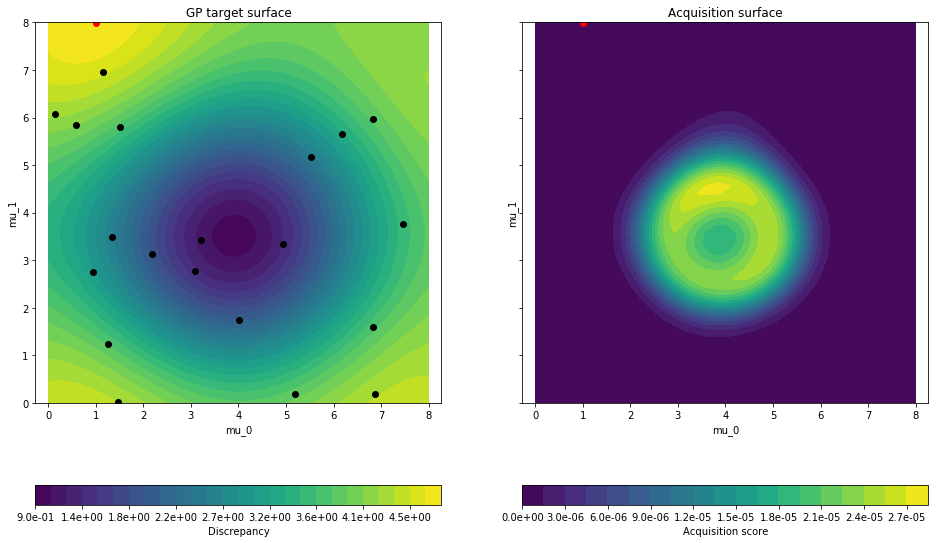

GP_regression.,value,constraints,priors
sum.rbf.variance,1.76636589357,+ve,"Ga(2.4, 1)"
sum.rbf.lengthscale,2.54756093174,+ve,"Ga(2.7, 1)"
sum.bias.variance,2.08308698792,+ve,"Ga(0.61, 1)"
Gaussian_noise.variance,0.12601573588,+ve,


In [7]:
n_pts_fit = 11
n_pts_total = n_pts_initial + n_pts_fit
post_maxvar = bolfi_maxvar.fit(n_evidence=n_pts_total, vis=True)

### 3. Comparison between the Maxvar (as well as RandMaxVar) and LCB (ELFI default) acquisition methods.

Here, we compare the performance of the MaxVar and LCB acquisitions methods in terms of the KL divergence and Total Variantion (TV) metrics. We use the finite TV metric as described in [Wikipedia](https://en.wikipedia.org/wiki/Total_variation_distance_of_probability_measures).

As the evaluation takes time, the notebook provides the options to save and load previously fit models and results. Note that the files are saved and accessed from the directory the Notebook is ran. We also provide files with pre-fit models and results; these can be downloaded via `TODO: insert_link_here`.

To load the files, make sure `load` is set to `True`; after the file is loaded, one should look into the keys of `models` and set the chosen to `name_value`. Otherwise, the notebook will create a new model with the default settings set below.

In [12]:
load = False
save_results = True
params_true_mu = [4, 4]
sigma_ii = 1.
sigma_ij = .5
n_pts_initial = 20

models = np.load('models.npy').item()

# print(models)
# np.save('models.npy', {})
# print(1/0)

name_model = '1503054158.82589'
if load:
    bolfi_lcb = models[name_model]['lcb']
    bolfi_maxvar = models[name_model]['maxvar']
    bolfi_randmaxvar = models[name_model]['randmaxvar']
else:
    model_lcb = gauss_nd.get_model(cov_ij=sigma_ij, cov_ii=sigma_ii, true_params=params_true_mu)
    model_maxvar = gauss_nd.get_model(cov_ij=sigma_ij, cov_ii=sigma_ii, true_params=params_true_mu)
    model_randmaxvar = gauss_nd.get_model(cov_ij=sigma_ij, cov_ii=sigma_ii, true_params=params_true_mu)
    d_lcb = model_lcb['d']
    d_maxvar = model_maxvar['d']
    d_randmaxvar = model_randmaxvar['d']
    
    bounds = {'mu_0':(0, 8), 'mu_1':(0, 8)}
    names_parameter = d_maxvar.model.parameter_names
    
    target_model_maxvar = GPyRegression(names_parameter, bounds=bounds)
    prior_maxvar = ModelPrior(d_maxvar.model)
    target_model_randmaxvar = GPyRegression(names_parameter, bounds=bounds)
    prior_randmaxvar = ModelPrior(d_randmaxvar.model)
    
    maxvar_acq = MaxVar(model=target_model_maxvar, prior=prior_maxvar, n_inits=25, percentile_eps=10)
    randmaxvar_acq = RandMaxVar(model=target_model_randmaxvar, prior=prior_randmaxvar, n_inits=25,
                                percentile_eps=10)
    
    bolfi_lcb = elfi.BOLFI(d_lcb, initial_evidence=n_pts_initial, update_interval=1, 
                           bounds=bounds)
    bolfi_maxvar = elfi.BOLFI(d_maxvar, acquisition_method=maxvar_acq, target_model=target_model_maxvar,
                              initial_evidence=n_pts_initial, update_interval=1, 
                              bounds=bounds)
    bolfi_randmaxvar = elfi.BOLFI(d_randmaxvar, acquisition_method=randmaxvar_acq,
                                  target_model=target_model_randmaxvar, initial_evidence=n_pts_initial,
                                  update_interval=1, bounds=bounds)

If the model was loaded, the notebook will automatically choose its last fitting iteration point. New acquisition points are set by `n_pts_acq`. 

For the evaluation, we go in increments of 1 in fitting and sampling the model. Note that the number of posterior samples is controlled by `n_pts_post`.

Lastly, one can enable or disable the saving of the new results in the `save_results` setting.

In [14]:
import time

new_model = True
n_pts_acq = 40
n_pts_post = 25

# Read results and set the starting indexI.
results = np.load('results_dict.npy').item()

# print(len(results.keys()))
# np.save('results_dict.npy', {})
# print(1/0)

if new_model:
    idx_iter_start = n_pts_initial
    name_model = str(time.time())
    models[name_model] = {}
    results[name_model] = {}
else:
    idx_iter_start = np.sort(list(results[name_model].keys()))[-1]+1

# Choose the ending interation point based on the loaded model
lcb_times = []
maxvar_times = []
randmaxvar_times = []

idx_iter_end = idx_iter_start + n_pts_acq
for n_pts_fit in range(idx_iter_start, idx_iter_end):
#     Fitting the model.
    print('Acquisition: {}/{}'.format(n_pts_fit+1, idx_iter_end))
    start_lcb = time.time()
    post_lcb = bolfi_lcb.fit(n_evidence=n_pts_fit, threshold=.5)
    end_lcb = time.time()-start_lcb
    lcb_times.append(end_lcb)
    start_maxvar = time.time()
    post_maxvar = bolfi_maxvar.fit(n_evidence=n_pts_fit, threshold=.5)
    end_maxvar = time.time()-start_maxvar
    maxvar_times.append(end_maxvar)
    start_randmaxvar = time.time()
    post_randmaxvar = bolfi_randmaxvar.fit(n_evidence=n_pts_fit, threshold=.5)
    end_randmaxvar = time.time()-start_randmaxvar
    randmaxvar_times.append(end_randmaxvar)

#     Estimating the parameters.
    samples_lcb = bolfi_lcb.sample(n_pts_post)
    samples_maxvar = bolfi_maxvar.sample(n_pts_post)
    samples_randmaxvar = bolfi_randmaxvar.sample(n_pts_post)

#     Save the results.
    params_lcb = [samples_lcb.sample_means['mu_0'], samples_lcb.sample_means['mu_1']]
    params_maxvar = [samples_maxvar.sample_means['mu_0'], samples_maxvar.sample_means['mu_1']]
    params_randmaxvar = [samples_randmaxvar.sample_means['mu_0'], samples_randmaxvar.sample_means['mu_1']]
    results[name_model][n_pts_fit] = {'lcb': params_lcb, 'maxvar': params_maxvar,
                                      'randmaxvar': params_randmaxvar}

if save_results:
    models[name_model]['lcb'] = bolfi_lcb
    models[name_model]['maxvar'] = bolfi_maxvar
    models[name_model]['randmaxcar'] = bolfi_randmaxvar
#     np.save('models.npy', models)
    np.save('results_dict.npy', results)

Acquisition: 21/60


NUTS: Diverged proposals after warmup (i.e. n_adapt=12 steps): 1


Acquisition: 22/60


NUTS: Diverged proposals after warmup (i.e. n_adapt=12 steps): 1
NUTS: Diverged proposals after warmup (i.e. n_adapt=12 steps): 1
 /Users/perdaugmazas/Projects/bolfi/elfi/elfi/methods/mcmc.py:207: RuntimeWarning:overflow encountered in exp
NUTS: Diverged proposals after warmup (i.e. n_adapt=12 steps): 1


Acquisition: 23/60


NUTS: Diverged proposals after warmup (i.e. n_adapt=12 steps): 1
 /Users/perdaugmazas/Projects/bolfi/elfi/elfi/methods/posteriors.py:180: RuntimeWarning:invalid value encountered in true_divide


Acquisition: 24/60
Acquisition: 25/60
Acquisition: 26/60
Acquisition: 27/60
Acquisition: 28/60
Acquisition: 29/60
Acquisition: 30/60
Acquisition: 31/60
Acquisition: 32/60
Acquisition: 33/60
Acquisition: 34/60
Acquisition: 35/60
Acquisition: 36/60
Acquisition: 37/60
Acquisition: 38/60
Acquisition: 39/60
Acquisition: 40/60
Acquisition: 41/60
Acquisition: 42/60
Acquisition: 43/60
Acquisition: 44/60
Acquisition: 45/60
Acquisition: 46/60
Acquisition: 47/60
Acquisition: 48/60
Acquisition: 49/60
Acquisition: 50/60
Acquisition: 51/60
Acquisition: 52/60
Acquisition: 53/60
Acquisition: 54/60
Acquisition: 55/60
Acquisition: 56/60
Acquisition: 57/60
Acquisition: 58/60
Acquisition: 59/60
Acquisition: 60/60


Comparing the acquisition performance with respect to time.

In [15]:
print('Single LCB acquisition: {}'.format(np.average(lcb_times)))
print('Single MaxVar acquisition: {}'.format(np.average(maxvar_times)))
print('Single RandMaxVar acquisition: {}'.format(np.average(randmaxvar_times)))

Single LCB acquisition: 0.6186406135559082
Single MaxVar acquisition: 0.4838789880275726
Single RandMaxVar acquisition: 1.9697848677635192


Here, the code processes the obtain results and calculates the KL divergence and TV metrics.

In [16]:
%precision %.4g
from scipy.integrate import quad, dblquad
import scipy

sigma=[[1, .5], [.5, 1]]
pts_grid = 17
x1 = np.linspace(0, 8, pts_grid)
x2 = np.linspace(0, 8, pts_grid)
x1_mesh, x2_mesh = np.meshgrid(x1, x2)

tvs_lcb = []
tvs_maxvar = []
tvs_randmaxvar = []
kls_lcb = []
kls_maxvar = []
kls_randmaxvar = []
for n_pts_iter in range(n_pts_initial, idx_iter_end):
    params_lcb, params_maxvar, params_randmaxvar = results[name_model][n_pts_iter]['lcb'], \
        results[name_model][n_pts_iter]['maxvar'], results[name_model][n_pts_iter]['randmaxvar']
#     Initialising the density functions.
    fn_density_true = ss.multivariate_normal(mean=params_true_mu, cov=sigma).pdf
    fn_density_lcb = ss.multivariate_normal(mean=params_lcb, cov=sigma).pdf
    fn_density_maxvar = ss.multivariate_normal(mean=params_maxvar, cov=sigma).pdf
    fn_density_randmaxvar = ss.multivariate_normal(mean=params_randmaxvar, cov=sigma).pdf
    densities_true = np.zeros(shape=(pts_grid, pts_grid))
    densities_lcb = np.zeros(shape=(pts_grid, pts_grid))
    densities_maxvar = np.zeros(shape=(pts_grid, pts_grid))
    densities_randmaxvar = np.zeros(shape=(pts_grid, pts_grid))
#     Obtaining the dentisities and grid point coordinates.
    for i in range(pts_grid):
        for j in range(pts_grid):
            densities_true[i][j] = fn_density_true(x=[x1_mesh[i][j], x2_mesh[i][j]])
            densities_lcb[i][j] = fn_density_lcb(x=[x1_mesh[i][j], x2_mesh[i][j]])
            densities_maxvar[i][j] = fn_density_maxvar(x=[x1_mesh[i][j], x2_mesh[i][j]])
            densities_randmaxvar[i][j] = fn_density_randmaxvar(x=[x1_mesh[i][j], x2_mesh[i][j]])
#     Normalising the densities.
    densities_true = densities_true / densities_true.sum()
    densities_lcb = densities_lcb / densities_lcb.sum()
    densities_maxvar = densities_maxvar / densities_maxvar.sum()
    densities_randmaxvar = densities_randmaxvar / densities_randmaxvar.sum()
#     Calculating the tv values.
    tv_lcb = .5*np.abs(densities_lcb - densities_true).sum()
    tv_maxvar = .5*np.abs(densities_maxvar - densities_true).sum()
    tv_randmaxvar = .5*np.abs(densities_randmaxvar - densities_true).sum()
    tvs_lcb.append(tv_lcb)
    tvs_maxvar.append(tv_maxvar)
    tvs_randmaxvar.append(tv_randmaxvar)
#     Calculating the KL values
    kl_lcb = ss.entropy(densities_lcb.ravel(), densities_true.ravel())
    kl_maxvar = ss.entropy(densities_maxvar.ravel(), densities_true.ravel())
    kl_randmaxvar = ss.entropy(densities_randmaxvar.ravel(), densities_true.ravel())
    kls_lcb.append(kl_lcb)
    kls_maxvar.append(kl_maxvar)
    kls_randmaxvar.append(kl_randmaxvar)

Finally, we observe the achieved performance. Note that we are comparing the parameter values obtained using the MaxVar and LCB acquisition methods with respect to the true parameter values. 

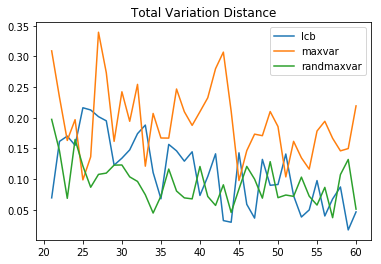

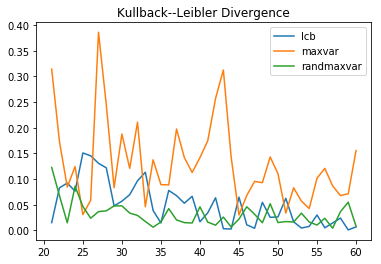

In [17]:
x = np.linspace(n_pts_initial+1, idx_iter_end, idx_iter_end-n_pts_initial)
plt.plot(x, tvs_lcb, label='lcb')
plt.plot(x, tvs_maxvar, label='maxvar')
plt.plot(x, tvs_randmaxvar, label='randmaxvar')
plt.title('Total Variation Distance')
plt.legend()
plt.show()
plt.plot(x, kls_lcb, label='lcb')
plt.plot(x, kls_maxvar, label='maxvar')
plt.plot(x, kls_randmaxvar, label='randmaxvar')
plt.title('Kullback--Leibler Divergence')
plt.legend()
plt.show()

### 4. Averaging out a collection of experiments.

Calculating the performance.

In [18]:
results = np.load('results_dict.npy').item()
n_pts_initial = 20
n_pts_acq = 40
sigma=[[1, .5], [.5, 1]]
params_true_mu = [4, 4]
pts_grid = 17
x1 = np.linspace(0, 8, pts_grid)
x2 = np.linspace(0, 8, pts_grid)
x1_mesh, x2_mesh = np.meshgrid(x1, x2)

idx_iter_end = n_pts_initial + n_pts_acq
t_lcb = []
t_maxvar = []
t_randmaxvar = []
k_lcb = []
k_maxvar = []
k_randmaxvar = []
for name_model in results.keys():
    tvs_lcb = []
    tvs_maxvar = []
    tvs_randmaxvar = []
    kls_lcb = []
    kls_maxvar = []
    kls_randmaxvar = []
    for n_pts_iter in range(n_pts_initial, idx_iter_end):
        params_lcb, params_maxvar, params_randmaxvar = results[name_model][n_pts_iter]['lcb'], \
            results[name_model][n_pts_iter]['maxvar'], results[name_model][n_pts_iter]['randmaxvar']
    #     Initialising the density functions.
        fn_density_true = ss.multivariate_normal(mean=params_true_mu, cov=sigma).pdf
        fn_density_lcb = ss.multivariate_normal(mean=params_lcb, cov=sigma).pdf
        fn_density_maxvar = ss.multivariate_normal(mean=params_maxvar, cov=sigma).pdf
        fn_density_randmaxvar = ss.multivariate_normal(mean=params_randmaxvar, cov=sigma).pdf
        densities_true = np.zeros(shape=(pts_grid, pts_grid))
        densities_lcb = np.zeros(shape=(pts_grid, pts_grid))
        densities_maxvar = np.zeros(shape=(pts_grid, pts_grid))
        densities_randmaxvar = np.zeros(shape=(pts_grid, pts_grid))
    #     Obtaining the dentisities and grid point coordinates.
        for i in range(pts_grid):
            for j in range(pts_grid):
                densities_true[i][j] = fn_density_true(x=[x1_mesh[i][j], x2_mesh[i][j]])
                densities_lcb[i][j] = fn_density_lcb(x=[x1_mesh[i][j], x2_mesh[i][j]])
                densities_maxvar[i][j] = fn_density_maxvar(x=[x1_mesh[i][j], x2_mesh[i][j]])
                densities_randmaxvar[i][j] = fn_density_randmaxvar(x=[x1_mesh[i][j], x2_mesh[i][j]])
    #     Normalising the densities.
        densities_true = densities_true / densities_true.sum()
        densities_lcb = densities_lcb / densities_lcb.sum()
        densities_maxvar = densities_maxvar / densities_maxvar.sum()
        densities_randmaxvar = densities_randmaxvar / densities_randmaxvar.sum()
    #     Calculating the tv values.
        tv_lcb = .5*np.abs(densities_lcb - densities_true).sum()
        tv_maxvar = .5*np.abs(densities_maxvar - densities_true).sum()
        tv_randmaxvar = .5*np.abs(densities_randmaxvar - densities_true).sum()
        tvs_lcb.append(tv_lcb)
        tvs_maxvar.append(tv_maxvar)
        tvs_randmaxvar.append(tv_randmaxvar)
    #     Calculating the KL values
        kl_lcb = ss.entropy(densities_lcb.ravel(), densities_true.ravel())
        kl_maxvar = ss.entropy(densities_maxvar.ravel(), densities_true.ravel())
        kl_randmaxvar = ss.entropy(densities_randmaxvar.ravel(), densities_true.ravel())
        kls_lcb.append(kl_lcb)
        kls_maxvar.append(kl_maxvar)
        kls_randmaxvar.append(kl_randmaxvar)
    t_lcb.append(tvs_lcb)
    t_maxvar.append(tvs_maxvar)
    t_randmaxvar.append(tvs_randmaxvar)
    k_lcb.append(kls_lcb)
    k_maxvar.append(kls_maxvar)
    k_randmaxvar.append(kls_randmaxvar)

Plotting the results.

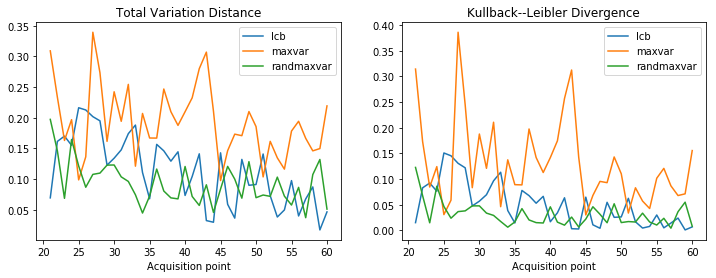

In [19]:
x = np.linspace(n_pts_initial+1, idx_iter_end, idx_iter_end-n_pts_initial)

fig, arr_ax = plt.subplots(nrows=1,
                           ncols=2,
                           figsize=(12, 4),
                           sharex=True)

arr_ax[0].plot(x, np.average(t_lcb, axis=0), label='lcb')
arr_ax[0].plot(x, np.average(t_maxvar, axis=0), label='maxvar')
arr_ax[0].plot(x, np.average(t_randmaxvar, axis=0), label='randmaxvar')
arr_ax[0].set_title('Total Variation Distance')
arr_ax[0].legend()
arr_ax[0].set_xlabel('Acquisition point')
arr_ax[1].plot(x, np.average(k_lcb, axis=0), label='lcb')
arr_ax[1].plot(x, np.average(k_maxvar, axis=0), label='maxvar')
arr_ax[1].plot(x, np.average(k_randmaxvar, axis=0), label='randmaxvar')
arr_ax[1].set_title('Kullback--Leibler Divergence')
arr_ax[1].legend()
arr_ax[1].set_xlabel('Acquisition point')